<div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 40px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.3);'>
    <h1 style='color: white; text-align: center; font-size: 48px; margin: 0; font-weight: 800; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>CRÉDIT SCORING</h1>
    <h2 style='color: #e0e7ff; text-align: center; font-size: 28px; margin-top: 15px; font-weight: 300;'>Preprocessing & Feature Engineering</h2>
    <p style='color: white; text-align: center; font-size: 16px; margin-top: 20px; opacity: 0.9;'>Projet CLF02 - Prêt à dépenser</p>
</div>

<div class='section-header'>
    <h2 style='margin: 0;'>1. SETUP & CHARGEMENT</h2>
</div>

In [11]:
# Imports et configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Taille par défaut des figures
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

import sys
sys.path.insert(0, '..')

print("✓ Imports réussis")

✓ Imports réussis


In [12]:
# Chargement des données
DATA_PATH = Path('../data/merged')

print("Chargement de train_merged.csv...")
train = pd.read_csv(DATA_PATH / 'train_merged.csv')
test = pd.read_csv(DATA_PATH / 'test_merged.csv')

print(f"✓ Train chargé : {train.shape[0]:,} lignes × {train.shape[1]} colonnes")
print(f"✓ Test chargé : {test.shape[0]:,} lignes × {test.shape[1]} colonnes")
print(f"Mémoire train : {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Chargement de train_merged.csv...
✓ Train chargé : 307,511 lignes × 184 colonnes
✓ Test chargé : 48,744 lignes × 183 colonnes
Mémoire train : 650.44 MB


<div class='section-header'>
    <h2 style='margin: 0;'>2. GESTION DES VALEURS MANQUANTES</h2>
</div>

In [13]:
from src.preprocessors.missing_handler import MissingValuesHandler

# Initialiser le handler
missing_handler = MissingValuesHandler()

# Fit sur train
print("Fitting MissingValuesHandler sur train...")
missing_handler.fit(train)

# Transform train et test
print("\nTransformation train...")
train_nomiss = missing_handler.transform(train)

print("\nTransformation test...")
test_nomiss = missing_handler.transform(test)

print(f"\n✓ Shape après traitement:")
print(f"  Train: {train_nomiss.shape}")
print(f"  Test: {test_nomiss.shape}")

print(f"\n✓ Nouvelles features créées: {len(missing_handler.new_features)}")
for feat in missing_handler.new_features:
    print(f"  - {feat}")

Fitting MissingValuesHandler sur train...

FIT: Apprentissage des paramètres (médianes)

Médianes calculées pour 124 variables
Exemples:
   - EXT_SOURCE_1: 0.505998
   - EXT_SOURCE_2: 0.565961
   - EXT_SOURCE_3: 0.535276
   - DAYS_EMPLOYED: -1648.000000
   - APARTMENTS_AVG: 0.087600

Transformation train...

TRANSFORM: Application des transformations

1. Création des indicateurs binaires...
   - Tables auxiliaires: 5 indicateurs créés
   - EXT_SOURCE: 3 indicateurs créés
   - DAYS_EMPLOYED_ANOM: 55,374 anomalies détectées (18.01%)

Total: 9 nouvelles features créées

2. Imputation par catégorie...
   - Tables auxiliaires: 62 colonnes → 0
   - EXT_SOURCE: 3 colonnes → médiane
   - Variables conditionnelles: 2 colonnes → -1
   - Variables catégorielles: 6 colonnes → 'Unknown'
   - Requêtes Bureau: 6 colonnes → 0
   - Variables immobilières: 40 colonnes → médiane
   - DAYS_EMPLOYED: → médiane (-1648 jours)
   - Autres numériques: imputées par médiane

Valeurs manquantes restantes: 0
Succè

### 2.1 Validation - Valeurs manquantes résiduelles

In [14]:
# Vérifier qu'il ne reste aucune valeur manquante
missing_train = train_nomiss.isnull().sum().sum()
missing_test = test_nomiss.isnull().sum().sum()

print("="*60)
print("VALIDATION - VALEURS MANQUANTES RÉSIDUELLES")
print("="*60)
print(f"Train: {missing_train} valeurs manquantes")
print(f"Test: {missing_test} valeurs manquantes")

if missing_train == 0 and missing_test == 0:
    print("\n✓ VALIDATION RÉUSSIE: Aucune valeur manquante!")
else:
    print("\n⚠ ATTENTION: Des valeurs manquantes persistent!")

VALIDATION - VALEURS MANQUANTES RÉSIDUELLES
Train: 0 valeurs manquantes
Test: 0 valeurs manquantes

✓ VALIDATION RÉUSSIE: Aucune valeur manquante!


<div class='section-header'>
    <h2 style='margin: 0;'>3. TRAITEMENT DES OUTLIERS</h2>
</div>

In [15]:
from src.preprocessors.outlier_handler import OutlierHandler

# Analyser les outliers AVANT traitement
print("="*60)
print("ANALYSE DES OUTLIERS (méthode IQR)")
print("="*60)

outlier_handler = OutlierHandler(method='winsorize', apply_all_methods=False)
outlier_handler.fit(train_nomiss)  # Fit nécessaire avant detect_outliers_summary
summary = outlier_handler.detect_outliers_summary(train_nomiss)

print(f"\nVariables avec outliers détectés: {len(summary)}")
print("\nTop 10 variables avec le plus d'outliers:")
print(summary.head(10).to_string())

ANALYSE DES OUTLIERS (méthode IQR)

FIT: Calcul des bornes (winsorize)

Nombre de variables à traiter: 175

Bornes calculées pour 175 variables

Exemples de bornes:
   - CNT_CHILDREN: [0.00, 2.00]
   - AMT_INCOME_TOTAL: [67500.00, 337500.00]
   - AMT_CREDIT: [135000.00, 1350000.00]
   - AMT_ANNUITY: [9000.00, 53325.00]
   - AMT_GOODS_PRICE: [135000.00, 1305000.00]

DETECTION DES OUTLIERS - Méthode IQR

Résumé des outliers:
   - Variables analysées: 175
   - Variables avec outliers (>0%): 166

Top 10 variables avec le plus d'outliers:
                    variable  n_outliers  pct_outliers
              LIVINGAREA_AVG      153089     49.783260
             LIVINGAREA_MEDI      153080     49.780333
             LIVINGAREA_MODE      152942     49.735457
             APARTMENTS_MEDI      151063     49.124422
              APARTMENTS_AVG      150931     49.081496
             APARTMENTS_MODE      143928     46.804179
YEARS_BEGINEXPLUATATION_MEDI      142141     46.223062
 YEARS_BEGINEXPLUATA

In [16]:
# APPLICATION DU TRAITEMENT (Mode SINGLE recommandé pour production)
print("\n" + "="*60)
print("APPLICATION: Mode SINGLE - Winsorization")
print("="*60)

# Fit sur train
outlier_handler.fit(train_nomiss)

# Transform
train_nooutliers = outlier_handler.transform(train_nomiss)
test_nooutliers = outlier_handler.transform(test_nomiss)

print(f"\n✓ Shape après traitement outliers:")
print(f"  Train: {train_nooutliers.shape}")
print(f"  Test: {test_nooutliers.shape}")


APPLICATION: Mode SINGLE - Winsorization

FIT: Calcul des bornes (winsorize)

Nombre de variables à traiter: 175

Bornes calculées pour 175 variables

Exemples de bornes:
   - CNT_CHILDREN: [0.00, 2.00]
   - AMT_INCOME_TOTAL: [67500.00, 337500.00]
   - AMT_CREDIT: [135000.00, 1350000.00]
   - AMT_ANNUITY: [9000.00, 53325.00]
   - AMT_GOODS_PRICE: [135000.00, 1305000.00]

TRANSFORM: Traitement des outliers (winsorize)

Application de la winsorisation...
   - 2,144,873 valeurs winsorisées sur 53,814,425
   - Pourcentage: 3.99%

TRANSFORM: Traitement des outliers (winsorize)

Application de la winsorisation...
   - 362,893 valeurs winsorisées sur 8,530,200
   - Pourcentage: 4.25%

✓ Shape après traitement outliers:
  Train: (307511, 193)
  Test: (48744, 192)


### 3.1 Visualisation - Impact du traitement outliers

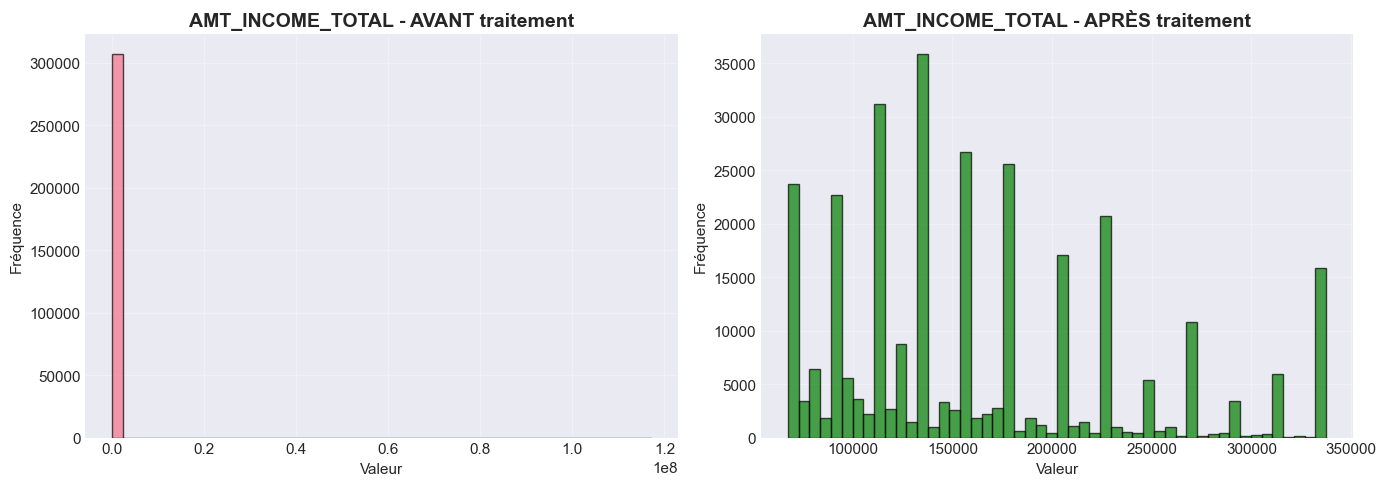


Statistiques AMT_INCOME_TOTAL:
  Avant - Min: 25,650 | Max: 117,000,000
  Après - Min: 67,500 | Max: 337,500


In [17]:
# Comparer distributions avant/après pour une variable exemple
example_var = 'AMT_INCOME_TOTAL'

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avant
axes[0].hist(train_nomiss[example_var].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title(f'{example_var} - AVANT traitement', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Valeur')
axes[0].set_ylabel('Fréquence')
axes[0].grid(alpha=0.3)

# Après
axes[1].hist(train_nooutliers[example_var].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'{example_var} - APRÈS traitement', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Valeur')
axes[1].set_ylabel('Fréquence')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatistiques {example_var}:")
print(f"  Avant - Min: {train_nomiss[example_var].min():,.0f} | Max: {train_nomiss[example_var].max():,.0f}")
print(f"  Après - Min: {train_nooutliers[example_var].min():,.0f} | Max: {train_nooutliers[example_var].max():,.0f}")

<div class='section-header'>
    <h2 style='margin: 0;'>4. FEATURE ENGINEERING</h2>
</div>

In [18]:
from src.preprocessors.feature_engineer import FeatureEngineer

print("="*60)
print("FEATURE ENGINEERING - 55+ FEATURES")
print("="*60)

# Initialiser
feature_engineer = FeatureEngineer(use_target_encoding=True, n_folds=5)

# Fit sur train (avec TARGET)
print("\nFitting FeatureEngineer sur train...")
feature_engineer.fit(train_nooutliers, train_nooutliers['TARGET'])

# Transform
print("\nTransformation train...")
train_fe = feature_engineer.transform(train_nooutliers)

print("\nTransformation test...")
test_fe = feature_engineer.transform(test_nooutliers)

print(f"\n✓ Shape après feature engineering:")
print(f"  Train: {train_fe.shape}")
print(f"  Test: {test_fe.shape}")

print(f"\n✓ Nouvelles features créées: {len(feature_engineer.get_feature_names())}")

FEATURE ENGINEERING - 55+ FEATURES

Fitting FeatureEngineer sur train...

FIT: Feature Engineering

3. Apprentissage Target Encoding K-Fold...
   - 12 variables préparées pour target encoding

Fit terminé

Transformation train...

TRANSFORM: Création des features

1. Création des ratios financiers...
   - 11 ratios financiers créés

2. Création des variables temporelles...
   - 14 variables temporelles créées

3. Application Target Encoding...
   - 12 variables encodées

4. Création des features d'interaction...
   - 20 features d'interaction créées

5. Création des flags de présence...
   - 3 flags de présence créés

Total nouvelles features créées: 60

Transformation test...

TRANSFORM: Création des features

1. Création des ratios financiers...
   - 11 ratios financiers créés

2. Création des variables temporelles...
   - 14 variables temporelles créées

3. Application Target Encoding...
   - 12 variables encodées

4. Création des features d'interaction...
   - 20 features d'interac

### 4.1 Détail des features créées

In [19]:
# Afficher les features par catégorie
new_features = feature_engineer.get_feature_names()

print("NOUVELLES FEATURES PAR CATÉGORIE")
print("="*60)

# Ratios financiers
ratios = [f for f in new_features if any(x in f for x in ['RATIO', 'INCOME', 'CREDIT', 'ANNUITY', 'TERM'])]
print(f"\n1. RATIOS FINANCIERS ({len(ratios)}):")
for feat in ratios[:5]:
    print(f"   - {feat}")
print(f"   ... et {len(ratios)-5} autres")

# Variables temporelles
temporal = [f for f in new_features if any(x in f for x in ['YEARS', 'AGE', 'EMPLOYED', 'IS_'])]
print(f"\n2. VARIABLES TEMPORELLES ({len(temporal)}):")
for feat in temporal[:5]:
    print(f"   - {feat}")
print(f"   ... et {len(temporal)-5} autres")

# Target encoding
te_features = [f for f in new_features if f.endswith('_TE')]
print(f"\n3. TARGET ENCODING ({len(te_features)}):")
for feat in te_features:
    print(f"   - {feat}")

# EXT_SOURCE interactions
ext_features = [f for f in new_features if 'EXT_SOURCE' in f and f not in ['HAS_EXT_SOURCE_1', 'HAS_EXT_SOURCE_2', 'HAS_EXT_SOURCE_3']]
print(f"\n4. INTERACTIONS EXT_SOURCE ({len(ext_features)}):")
for feat in ext_features[:5]:
    print(f"   - {feat}")
print(f"   ... et {len(ext_features)-5} autres")

# Flags
flags = [f for f in new_features if f.startswith('HAS_')]
print(f"\n5. FLAGS DE PRÉSENCE ({len(flags)}):")
for feat in flags:
    print(f"   - {feat}")

NOUVELLES FEATURES PAR CATÉGORIE

1. RATIOS FINANCIERS (20):
   - CREDIT_INCOME_RATIO
   - ANNUITY_INCOME_RATIO
   - CREDIT_GOODS_RATIO
   - ANNUITY_CREDIT_RATIO
   - INCOME_PER_FAMILY_MEMBER
   ... et 15 autres

2. VARIABLES TEMPORELLES (18):
   - CREDIT_TERM_YEARS
   - AGE_YEARS
   - EMPLOYED_YEARS
   - REGISTRATION_YEARS
   - ID_PUBLISH_YEARS
   ... et 13 autres

3. TARGET ENCODING (12):
   - NAME_CONTRACT_TYPE_TE
   - NAME_TYPE_SUITE_TE
   - NAME_INCOME_TYPE_TE
   - NAME_EDUCATION_TYPE_TE
   - NAME_FAMILY_STATUS_TE
   - NAME_HOUSING_TYPE_TE
   - OCCUPATION_TYPE_TE
   - WEEKDAY_APPR_PROCESS_START_TE
   - ORGANIZATION_TYPE_TE
   - FONDKAPREMONT_MODE_TE
   - HOUSETYPE_MODE_TE
   - WALLSMATERIAL_MODE_TE

4. INTERACTIONS EXT_SOURCE (16):
   - EXT_SOURCE_1_2
   - EXT_SOURCE_1_3
   - EXT_SOURCE_2_3
   - EXT_SOURCE_PROD
   - EXT_SOURCE_MEAN
   ... et 11 autres

5. FLAGS DE PRÉSENCE (3):
   - HAS_EXT_SOURCE_1
   - HAS_EXT_SOURCE_2
   - HAS_EXT_SOURCE_3


### 4.2 Visualisation - Top features créées

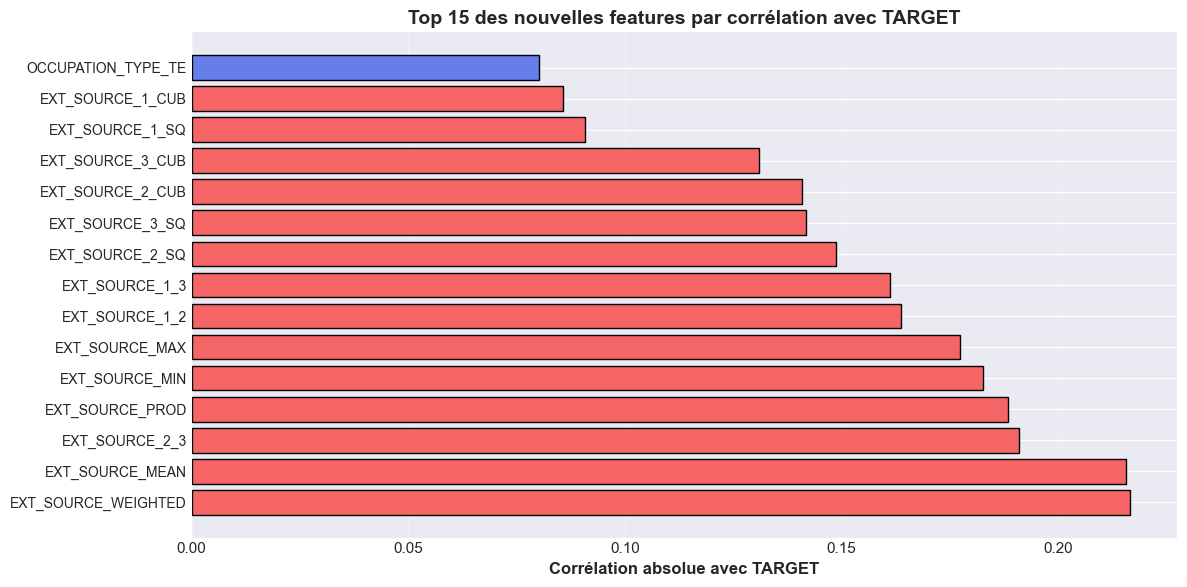


Top 5 features les plus corrélées:
1. EXT_SOURCE_WEIGHTED: 0.2165
2. EXT_SOURCE_MEAN: 0.2157
3. EXT_SOURCE_2_3: 0.1908
4. EXT_SOURCE_PROD: 0.1884
5. EXT_SOURCE_MIN: 0.1827

Note: 1 features catégorielles exclues de l'analyse de corrélation
  Ex: ['AGE_GROUP']


In [21]:
# Analyser la corrélation des nouvelles features avec TARGET
new_features_list = feature_engineer.get_feature_names()
available_features = [f for f in new_features_list if f in train_fe.columns]

# Filtrer uniquement les colonnes numériques
numeric_features = [f for f in available_features if train_fe[f].dtype in ['int64', 'float64', 'int32', 'float32']]

# Calculer corrélations
correlations = train_fe[numeric_features + ['TARGET']].corr()['TARGET'].drop('TARGET')
correlations = correlations.abs().sort_values(ascending=False)

# Top 15
top_corr = correlations.head(15)

plt.figure(figsize=(12, 6))
colors = ['#667eea' if x > 0 else '#f56565' for x in train_fe[top_corr.index].corrwith(train_fe['TARGET'])]
plt.barh(range(len(top_corr)), top_corr.values, color=colors, edgecolor='black')
plt.yticks(range(len(top_corr)), top_corr.index, fontsize=10)
plt.xlabel('Corrélation absolue avec TARGET', fontsize=12, fontweight='bold')
plt.title('Top 15 des nouvelles features par corrélation avec TARGET', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 features les plus corrélées:")
for i, (feat, corr) in enumerate(top_corr.head(5).items(), 1):
    print(f"{i}. {feat}: {corr:.4f}")

# Afficher les features catégorielles exclues
categorical_features = [f for f in available_features if f not in numeric_features]
if categorical_features:
    print(f"\nNote: {len(categorical_features)} features catégorielles exclues de l'analyse de corrélation")
    print(f"  Ex: {categorical_features[:3]}")

<div class='section-header'>
    <h2 style='margin: 0;'>5. ENCODAGE CATÉGORIEL</h2>
</div>

In [22]:
from src.preprocessors.encoder import CategoricalEncoder

print("="*60)
print("ENCODAGE CATÉGORIEL - 3 MÉTHODES")
print("="*60)

# Initialiser
encoder = CategoricalEncoder(
    target_encoding_vars=[
        'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
        'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
        'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'
    ],
    onehot_vars=[
        'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_CONTRACT_TYPE', 'EMERGENCYSTATE_MODE'
    ],
    n_folds=5
)

# Fit sur train
print("\nFitting CategoricalEncoder sur train...")
encoder.fit(train_fe, train_fe['TARGET'])

# Transform
print("\nTransformation train...")
train_encoded = encoder.transform(train_fe)

print("\nTransformation test...")
test_encoded = encoder.transform(test_fe)

# Supprimer colonnes catégorielles originales
train_final = encoder.drop_original_columns(train_encoded, keep_original=False)
test_final = encoder.drop_original_columns(test_encoded, keep_original=False)

print(f"\n✓ Shape final après encodage:")
print(f"  Train: {train_final.shape}")
print(f"  Test: {test_final.shape}")

print(f"\n✓ Features encodées: {len(encoder.get_feature_names())}")

ENCODAGE CATÉGORIEL - 3 MÉTHODES

Fitting CategoricalEncoder sur train...

FIT: Encodage des variables catégorielles

1. Apprentissage Target Encoding K-Fold...
   - 12 variables préparées pour target encoding
   - Moyenne globale TARGET: 0.0807

2. Apprentissage One-Hot Encoding...
   - 5 variables préparées
   - CODE_GENDER: 3 catégories
   - FLAG_OWN_CAR: binaire
   - FLAG_OWN_REALTY: binaire
   - NAME_CONTRACT_TYPE: binaire
   - EMERGENCYSTATE_MODE: 3 catégories

Fit terminé

Transformation train...

TRANSFORM: Application des encodages

1. Application Target Encoding...
   - 12 variables encodées

2. Application One-Hot Encoding...
   - 5 variables encodées
   - 7 nouvelles colonnes créées

Transformation test...

TRANSFORM: Application des encodages

1. Application Target Encoding...
   - 12 variables encodées

2. Application One-Hot Encoding...
   - 5 variables encodées
   - 7 nouvelles colonnes créées

Suppression des colonnes catégorielles originales...
   - 16 colonnes suppri

<div class='section-header'>
    <h2 style='margin: 0;'>6. RÉSUMÉ FINAL</h2>
</div>

In [23]:
print("="*70)
print("RÉSUMÉ DU PREPROCESSING PIPELINE")
print("="*70)

print("\nÉVOLUTION DU DATASET")
print("-" * 70)
print(f"{'Étape':<35} {'Train':<20} {'Test'}")
print("-" * 70)
print(f"{'1. Données brutes':<35} {str(train.shape):<20} {test.shape}")
print(f"{'2. Après missing values':<35} {str(train_nomiss.shape):<20} {test_nomiss.shape}")
print(f"{'3. Après outliers':<35} {str(train_nooutliers.shape):<20} {test_nooutliers.shape}")
print(f"{'4. Après feature engineering':<35} {str(train_fe.shape):<20} {test_fe.shape}")
print(f"{'5. Après encodage (FINAL)':<35} {str(train_final.shape):<20} {test_final.shape}")
print("-" * 70)

print("\nNOUVELLES FEATURES CRÉÉES")
print("-" * 70)
print(f"  MissingValuesHandler:     {len(missing_handler.new_features):>3} features")
print(f"  FeatureEngineer:          {len(feature_engineer.get_feature_names()):>3} features")
print(f"  CategoricalEncoder:       {len(encoder.get_feature_names()):>3} features")
print(f"  {'TOTAL:':<25} {len(missing_handler.new_features) + len(feature_engineer.get_feature_names()) + len(encoder.get_feature_names()):>3} nouvelles features")
print("-" * 70)

print("\n✓ VALIDATION FINALE")
print("-" * 70)
print(f"  Valeurs manquantes train: {train_final.isnull().sum().sum()}")
print(f"  Valeurs manquantes test:  {test_final.isnull().sum().sum()}")
print(f"  Valeurs infinies train:   {np.isinf(train_final.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Valeurs infinies test:    {np.isinf(test_final.select_dtypes(include=[np.number])).sum().sum()}")
print("-" * 70)

print("\nPRÊT POUR LA MODÉLISATION")

RÉSUMÉ DU PREPROCESSING PIPELINE

ÉVOLUTION DU DATASET
----------------------------------------------------------------------
Étape                               Train                Test
----------------------------------------------------------------------
1. Données brutes                   (307511, 184)        (48744, 183)
2. Après missing values             (307511, 193)        (48744, 192)
3. Après outliers                   (307511, 193)        (48744, 192)
4. Après feature engineering        (307511, 250)        (48744, 249)
5. Après encodage (FINAL)           (307511, 241)        (48744, 240)
----------------------------------------------------------------------

NOUVELLES FEATURES CRÉÉES
----------------------------------------------------------------------
  MissingValuesHandler:       9 features
  FeatureEngineer:           60 features
  CategoricalEncoder:        19 features
  TOTAL:                     88 nouvelles features
------------------------------------------------

<div class='section-header'>
    <h2 style='margin: 0;'>7. SAUVEGARDE</h2>
</div>

In [25]:
# Créer le répertoire processed si nécessaire
PROCESSED_PATH = Path('../data/processed')
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

print("Sauvegarde des données preprocessées...")

# Sauvegarder
train_final.to_csv(PROCESSED_PATH / 'train_final.csv', index=False)
test_final.to_csv(PROCESSED_PATH / 'test_final.csv', index=False)

print(f"\n✓ Données sauvegardées dans {PROCESSED_PATH}")
print(f"  - train_final.csv: {train_final.shape[0]:,} lignes × {train_final.shape[1]} colonnes")
print(f"  - test_final.csv: {test_final.shape[0]:,} lignes × {test_final.shape[1]} colonnes")

Sauvegarde des données preprocessées...

✓ Données sauvegardées dans ..\data\processed
  - train_final.csv: 307,511 lignes × 241 colonnes
  - test_final.csv: 48,744 lignes × 240 colonnes


In [26]:
# Sauvegarder le pipeline complet pour réutilisation
from src.pipeline import PreprocessingPipeline

ARTIFACTS_PATH = Path('../artifacts/preprocessing')
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)

print("\nSauvegarde du pipeline complet...")

# Créer et sauvegarder le pipeline
pipeline = PreprocessingPipeline(
    use_outlier_handler=True,
    outlier_method='winsorize',
    apply_all_outlier_methods=False,
    use_feature_engineering=True,
    use_target_encoding=True,
    use_categorical_encoding=True
)

# Fit sur données brutes
pipeline.fit(train, train['TARGET'])

# Sauvegarder
pipeline.save(ARTIFACTS_PATH)

print(f"\n✓ Pipeline sauvegardé dans {ARTIFACTS_PATH}")
print("  Artefacts créés:")
print("  - pipeline_config.pkl")
print("  - missing_handler.pkl")
print("  - outlier_handler.pkl")
print("  - feature_engineer.pkl")
print("  - categorical_encoder.pkl")


Sauvegarde du pipeline complet...

FIT PREPROCESSING PIPELINE
Dataset initial: (307511, 184)

--------------------------------------------------------------------------------
ÉTAPE 1: Missing Values Handler
--------------------------------------------------------------------------------

FIT: Apprentissage des paramètres (médianes)

Médianes calculées pour 124 variables
Exemples:
   - EXT_SOURCE_1: 0.505998
   - EXT_SOURCE_2: 0.565961
   - EXT_SOURCE_3: 0.535276
   - DAYS_EMPLOYED: -1648.000000
   - APARTMENTS_AVG: 0.087600

--------------------------------------------------------------------------------
ÉTAPE 2: Outlier Handler
--------------------------------------------------------------------------------

TRANSFORM: Application des transformations

1. Création des indicateurs binaires...
   - Tables auxiliaires: 5 indicateurs créés
   - EXT_SOURCE: 3 indicateurs créés
   - DAYS_EMPLOYED_ANOM: 55,374 anomalies détectées (18.01%)

Total: 9 nouvelles features créées

2. Imputation pa

<div style='background: linear-gradient(135deg, #10b981 0%, #059669 100%); padding: 30px; border-radius: 10px; margin-top: 30px;'>
    <h2 style='color: white; text-align: center; margin: 0;'>✓ PREPROCESSING TERMINÉ</h2>
    <p style='color: white; text-align: center; margin-top: 15px; font-size: 14px;'>Les données sont prêtes pour la Phase 4 : Modélisation</p>
</div>